In [7]:
symbols = ['PEP', 'KO']

[*********************100%%**********************]  2 of 2 completed
C:\Users\MP\AppData\Local\Temp\ipykernel_59268\3895388139.py:45: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['positions'] = data['positions'].replace(to_replace=0, method='ffill')


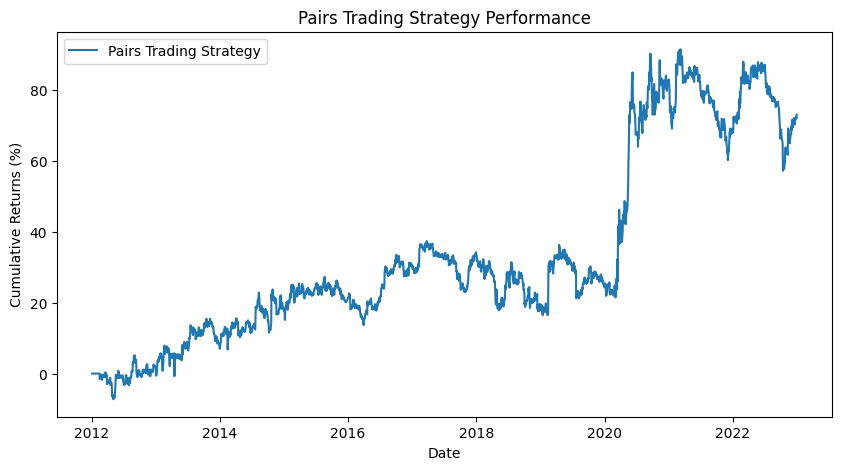

Final cumulative return: 73.08%


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

# Step 1: Download historical data
symbols = ['PEP', 'KO']
data = yf.download(symbols, start='2012-01-01', end='2023-01-01')['Adj Close']

# Step 2: Calculate the spread
# Calculate log prices
log_prices = np.log(data)
# Calculate the spread using a linear combination of the log prices
spread = log_prices['PEP'] - log_prices['KO']

# Step 3: Calculate the Z-score of the spread
def zscore(series):
    return (series - series.mean()) / np.std(series)

spread_zscore = zscore(spread)

# Step 4: Generate trading signals
entry_threshold = 2
exit_threshold = 1

# Buy signal (long PEP, short KO)
data['longs'] = spread_zscore < -entry_threshold
# Sell signal (short PEP, long KO)
data['shorts'] = spread_zscore > entry_threshold
# Exit signal (close positions)
data['exits'] = (spread_zscore > -exit_threshold) & (spread_zscore < exit_threshold)

# Initialize positions
data['positions'] = 0

# Long positions
data.loc[data['longs'], 'positions'] = 1
# Short positions
data.loc[data['shorts'], 'positions'] = -1
# Exit positions
data.loc[data['exits'], 'positions'] = 0

# Forward fill positions to maintain them until an exit signal
data['positions'] = data['positions'].replace(to_replace=0, method='ffill')

# Step 5: Calculate strategy returns
data['returns'] = data['positions'].shift(1) * (data['PEP'].pct_change() - data['KO'].pct_change())

# Calculate cumulative returns
data['cumulative_returns'] = (1 + data['returns']).cumprod()

# Convert cumulative returns to percentage
data['cumulative_returns_pct'] = (data['cumulative_returns'] - 1) * 100

# Plot cumulative returns
plt.figure(figsize=(10, 5))
plt.plot(data['cumulative_returns_pct'], label='Pairs Trading Strategy')
plt.title('Pairs Trading Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (%)')
plt.legend()
plt.show()

# Print final cumulative return in percentage
print(f"Final cumulative return: {data['cumulative_returns_pct'].iloc[-1]:.2f}%")
